In [1]:
!pip install torchsummary

In [2]:
import os                       
import numpy as np              
import pandas as pd             
import torch
import time
import copy

import torch.nn.functional as F 
import torchvision.transforms as transforms    
from torchvision.utils import make_grid       
from torchvision.datasets import ImageFolder  
from torchsummary import summary 
from torchvision import datasets, models
import torch.optim as optim

import matplotlib.pyplot as plt 
import torch.nn as nn           
from torch.utils.data import DataLoader  
from PIL import Image           


            

%matplotlib inline

## Analyzing the data

In [75]:
data_dir = "../New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [4]:
print("Total classes: {}".format(len(diseases)))

Total classes: 38


In [5]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
        
print("Plant species: \n{plants}")
print("Number of unique plant diseases: {}".format(NumberOfDiseases))


Plant species: 
{plants}
Number of unique plant diseases: 26


In [6]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Pepper,_bell___healthy                                       1988
Tomato___healthy                                             1926
Grape___Black_rot                                            1888
Strawberry___Leaf_scorch                                     1774
Strawberry___healthy                                         1824
Cherry_(including_sour)___Powdery_mildew                     1683
Corn_(maize)___Common_rust_                                  1907
Grape___healthy                                              1692
Peach___healthy                                              1728
Corn_(maize)___Northern_Leaf_Blight                          1908
Tomato___Leaf_Mold                                           1882
Apple___healthy                                              2008
Apple___Black_rot                                            1987
Squash___Powdery_mildew                                      1736
Orange___Haunglongbing_(Citrus_greening)                     2010
Raspberry___healthy                                          1781
Tomato___Target_Spot                                         1827
Tomato___Spider_mites Two-spotted_spider_mite                1741
Apple___Apple_scab                                           2016
Tomato___Early_blight                                        1920
Corn_(maize)___healthy                                       1859
Soybean___healthy                                            2022
Grape___Esca_(Black_Measles)                                 1920
Tomato___Bacterial_spot                                      1702
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Pepper,_bell___Bacterial_spot                                1913
Blueberry___healthy                                          1816
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Potato___Early_blight                                        1939
Peach___Bacterial_spot                                       1838
Cherry_(including_sour)___healthy                            1826
Tomato___Septoria_leaf_spot                                  1745
Potato___Late_blight                                         1939
Tomato___Tomato_mosaic_virus                                 1790
Apple___Cedar_apple_rust                                     1760
Potato___healthy                                             1824
Tomato___Late_blight                                         1851
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722

In [7]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"{n_train} images for training")

70295 images for training


In [76]:
batch_size = 32
input_size = 224 #Pre trained resnet
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# # datasets for validation and training
train = ImageFolder(train_dir)
valid = ImageFolder(valid_dir) 

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}


In [96]:
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
#     plt.imshow(image.permute(1, 2, 0))
    plt.imshow(image)

Label :Apple___Apple_scab(0)


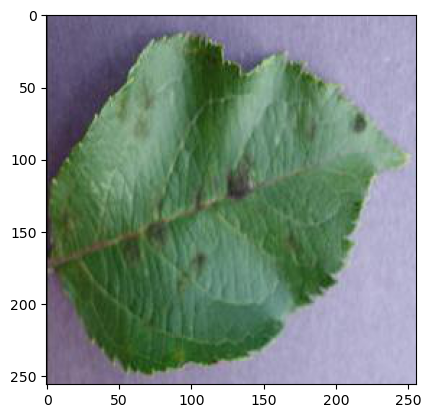

In [103]:
show_image(*valid[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


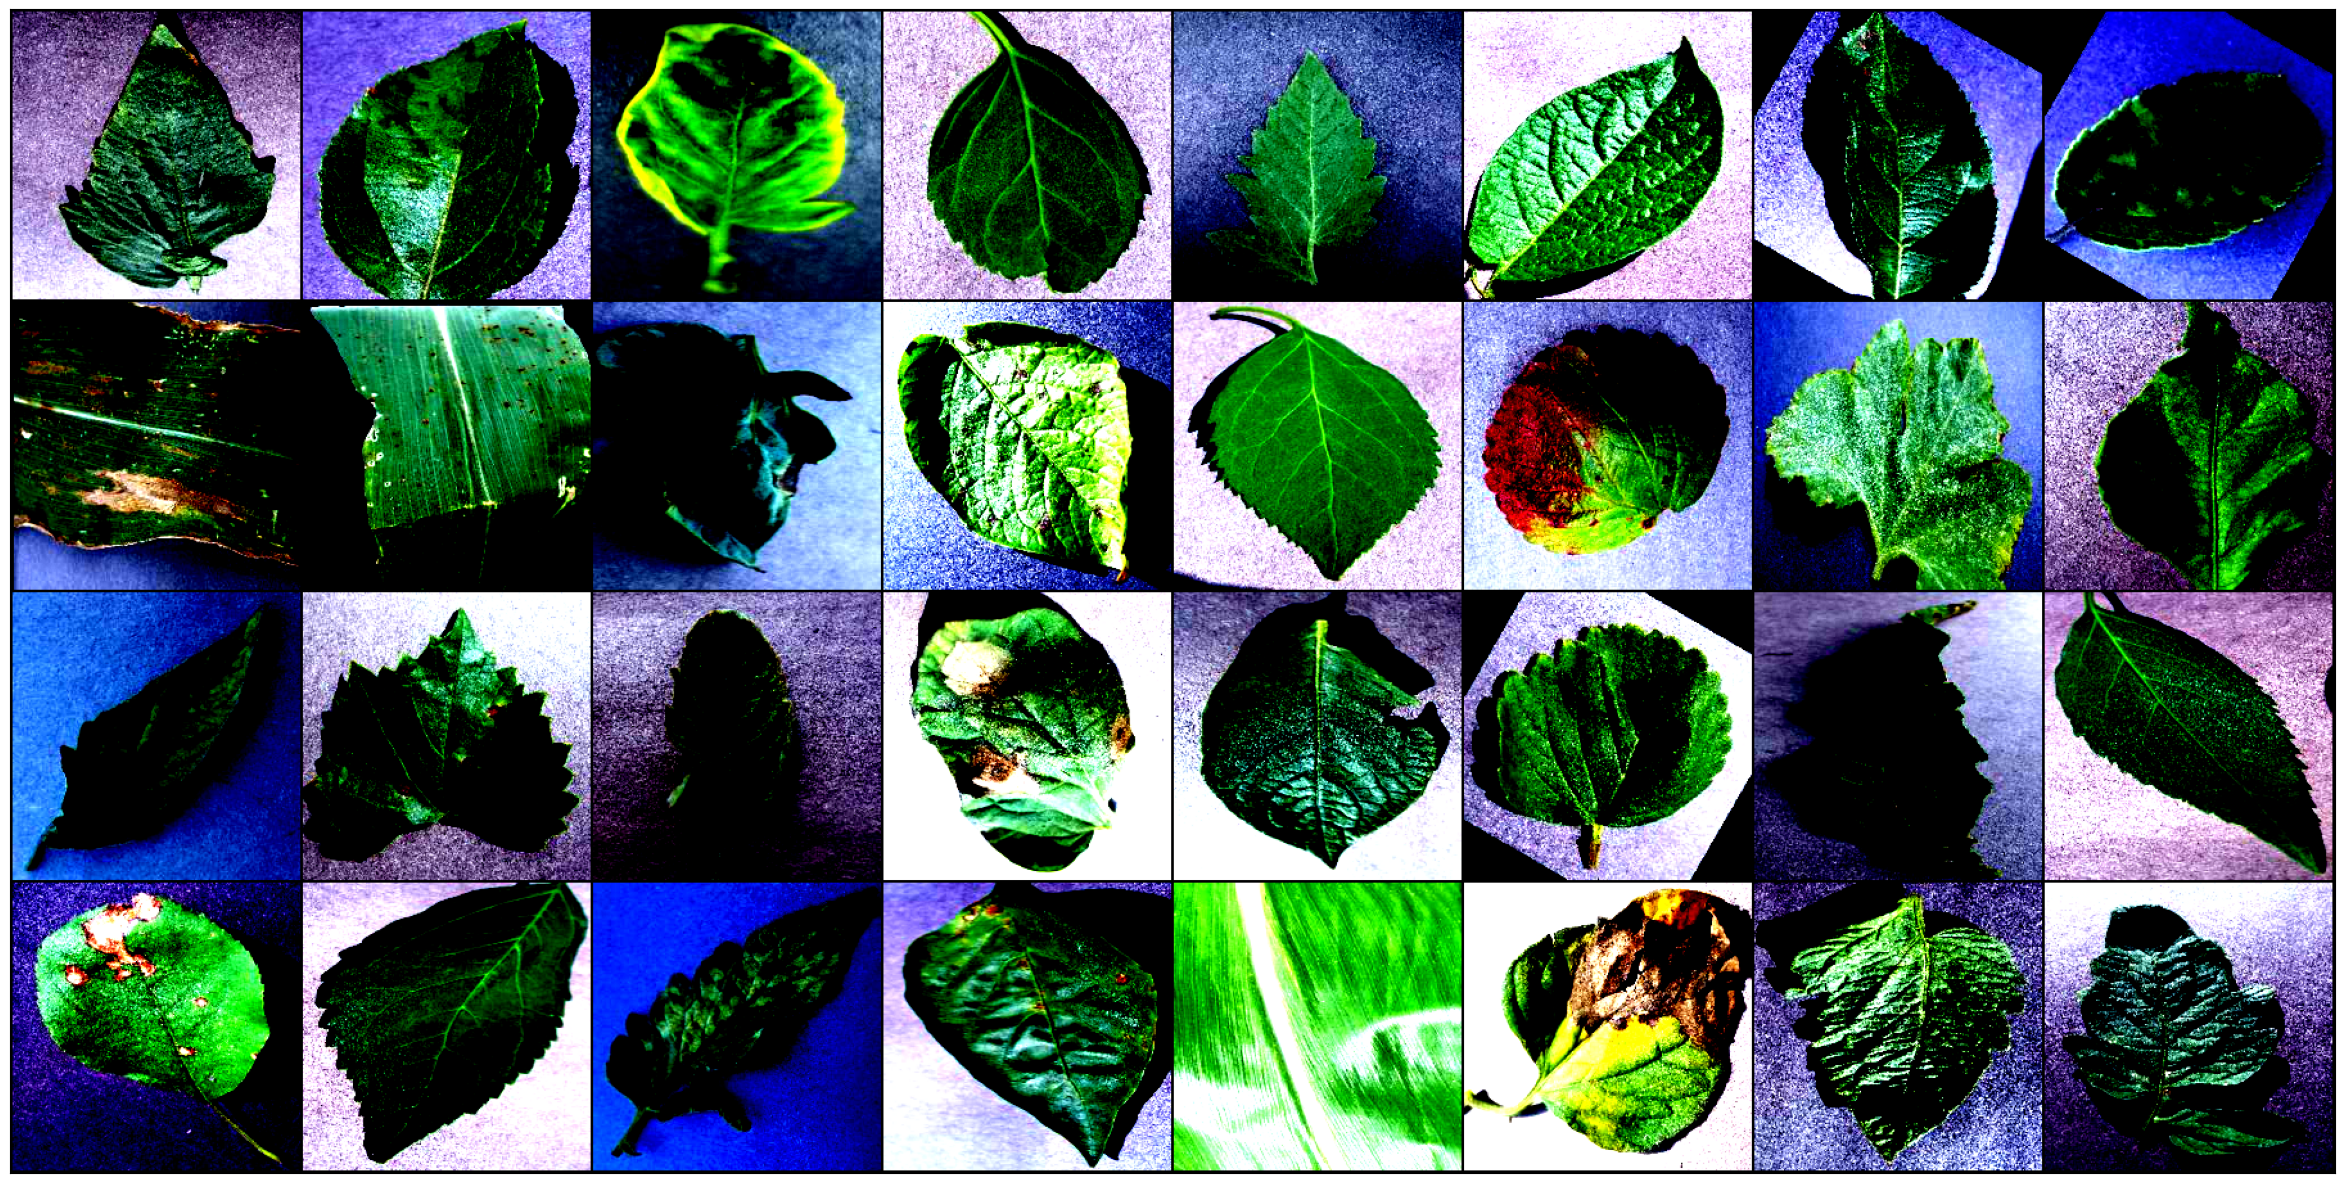

In [102]:
# Normalized batch of the leaves
for images, labels in dataloaders_dict['valid']:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

# Initializing torch objects

In [ ]:
# For recreation purpose
torch.manual_seed(0)

In [ ]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
        
# Images of first batch of training
show_batch(train_dl) 

In [13]:
# Defining model that is pretrained

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def init_pretrained_resnet18(num_classes, feature_extract=True, use_pretrained=True):

    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extracting=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

# Initialize the model for this run
model_pt, input_size = init_pretrained_resnet18(num_classes=38, feature_extract=True, use_pretrained=True)

# Print the model we just instantiated
print(model_pt)

/home/ms5267@drexel.edu/tmp/yes/envs/ve1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ms5267@drexel.edu/tmp/yes/envs/ve1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history



In [15]:
# If available device is cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_pt.to(device)

params_to_update = model_pt.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_pt.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
# else:
#     for name,param in model_pt.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [16]:

# Number of epochs to train for 
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)



Epoch 0/24
----------
train Loss: 1.3075 Acc: 0.7158
valid Loss: 0.5190 Acc: 0.8757

Epoch 1/24
----------
train Loss: 0.6807 Acc: 0.8259
valid Loss: 0.3877 Acc: 0.8956

Epoch 2/24
----------
train Loss: 0.5783 Acc: 0.8450
valid Loss: 0.3426 Acc: 0.9037

Epoch 3/24
----------
train Loss: 0.5293 Acc: 0.8543
valid Loss: 0.3134 Acc: 0.9065

Epoch 4/24
----------
train Loss: 0.4981 Acc: 0.8601
valid Loss: 0.3156 Acc: 0.9047

Epoch 5/24
----------
train Loss: 0.4743 Acc: 0.8653
valid Loss: 0.2675 Acc: 0.9207

Epoch 6/24
----------
train Loss: 0.4590 Acc: 0.8689
valid Loss: 0.2748 Acc: 0.9160

Epoch 7/24
----------
train Loss: 0.4426 Acc: 0.8707
valid Loss: 0.2727 Acc: 0.9154

Epoch 8/24
----------
train Loss: 0.4290 Acc: 0.8747
valid Loss: 0.2532 Acc: 0.9244

Epoch 9/24
----------
train Loss: 0.4281 Acc: 0.8743
valid Loss: 0.2537 Acc: 0.9220

Epoch 10/24
----------
train Loss: 0.4229 Acc: 0.8743
valid Loss: 0.2485 Acc: 0.9227

Epoch 11/24
----------
train Loss: 0.4085 Acc: 0.8785
valid Loss

In [18]:
path_model = './learned_model.pt'
torch.save(model_ft, path_model)

In [ ]:
batch_size = 32
input_size = 224 #Pre trained resnet
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# # datasets for validation and training
# train = ImageFolder(train_dir, transform=train_tranformations)
# valid = ImageFolder(valid_dir, transform=val_transformations) 

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}


In [33]:
label_agg =[]
prediction_agg = []

for inputs, labels in dataloaders_dict['valid']:
    outputs = model_ft(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    label_agg.append(labels)
    prediction_agg.append(preds)

## To create a confusion matrix

In [51]:
labels__ = []
predictions__ = []
for i in range(len(label_agg)):
    for val in label_agg[i]:
        labels__.append(val.item())
    for val in prediction_agg[i]:
        predictions__.append(val.item())
        

display_labels = np.arange(0,38)

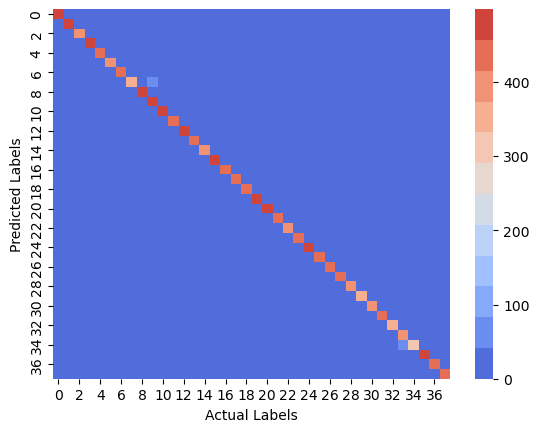

In [70]:
from sklearn import metrics
import seaborn as sn

confusion_matrix = metrics.confusion_matrix(labels__, predictions__)

plt.show()

cmap = sn.color_palette("coolwarm",12)

# plotting the heatmap
hm = sn.heatmap(data = confusion_matrix, cmap=cmap)
hm.set(xlabel='Actual Labels', ylabel='Predicted Labels')

# displaying the plotted heatmap
plt.show()

In [98]:
print(metrics.classification_report(labels__, predictions__, digits=3))

              precision    recall  f1-score   support

           0      0.961     0.938     0.950       504
           1      0.996     0.930     0.961       497
           2      0.958     0.927     0.942       440
           3      0.947     0.960     0.954       502
           4      0.901     0.978     0.938       454
           5      0.993     0.962     0.977       421
           6      0.980     0.985     0.982       456
           7      0.956     0.854     0.902       410
           8      0.986     1.000     0.993       477
           9      0.886     0.964     0.924       477
          10      1.000     0.989     0.995       465
          11      0.978     0.939     0.958       472
          12      0.938     0.979     0.958       480
          13      0.993     0.977     0.985       430
          14      0.974     0.979     0.976       423
          15      0.986     0.990     0.988       503
          16      0.952     0.954     0.953       459
          17      0.946    

## Loss & Accuracy by Epoch

In [35]:
x = np.arange(0,25)

train_loss = [1.3075,0.6807,0.5783,0.5293,0.4981,0.4743,0.4590,0.4426,0.4290,0.4281,0.4229,0.4085,0.4066,0.3978,0.3954,
              0.3925,0.3896,0.3836,0.3883,0.3781,0.3814,0.3748,0.3692,0.3698,0.3630]
valid_loss = [0.5190,0.3877,0.3426,0.3134,0.3156,0.2675,0.2748,0.2727,0.2532,0.2537,0.2485,0.2387,0.2332,0.2385,0.2334,
              0.2336,0.2251,0.2299,0.2171,0.2226,0.2108,0.2181,0.2140,0.2139,0.2208]
train_acc = [0.7158,0.8259,0.8450,0.8543,0.8601,0.8653,0.8689,0.8707,0.8747,0.8743,0.8743,0.8785,0.8782,0.8813,0.8817,
             0.8819,0.8825,0.8846,0.8832,0.8853,0.8854,0.8868,0.8871,0.8863,0.8892]
valid_acc = [0.8757,0.8956,0.9037,0.9065,0.9047,0.9207,0.9160,0.9154,0.9244,0.9220,0.9227,0.9256,0.9271,0.9251,0.9272,
             0.9248,0.9289,0.9276,0.9311,0.9293,0.9341,0.9302,0.9318,0.9325,0.9280]

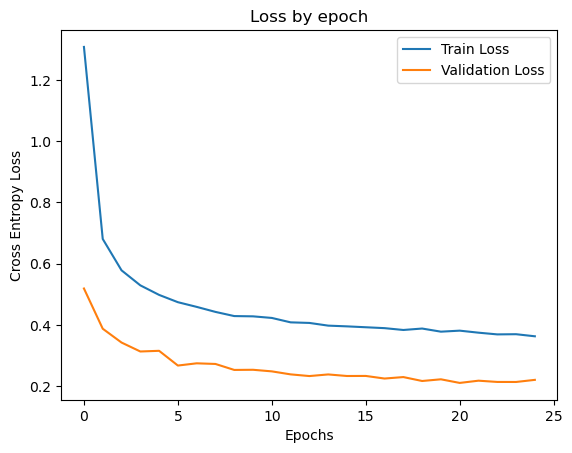

In [36]:
import matplotlib.pyplot as plt

plt.plot(x, train_loss, label='Train Loss')
plt.plot(x, valid_loss, '-', label='Validation Loss')

plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title('Loss by epoch')

plt.legend()
plt.show()

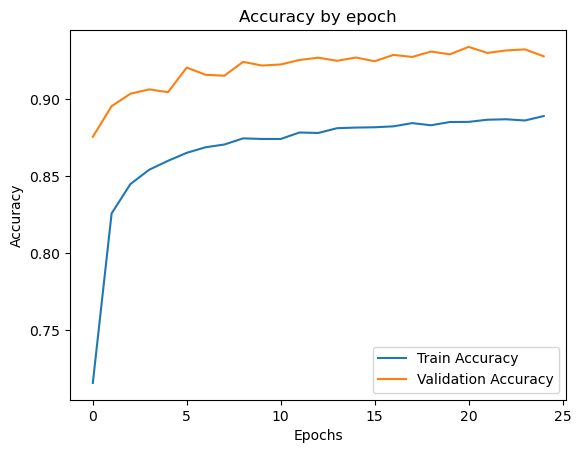

In [37]:
import matplotlib.pyplot as plt

plt.plot(x, train_acc, label='Train Accuracy')
plt.plot(x, valid_acc, '-', label='Validation Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy by epoch')

plt.legend()
plt.show()

In [155]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

idx_to_class_names = find_classes(valid_dir)


Label :Apple___Cedar_apple_rust(2)

Predicted Label: Apple___Cedar_apple_rust 
Softmax Score: 0.9706792235374451


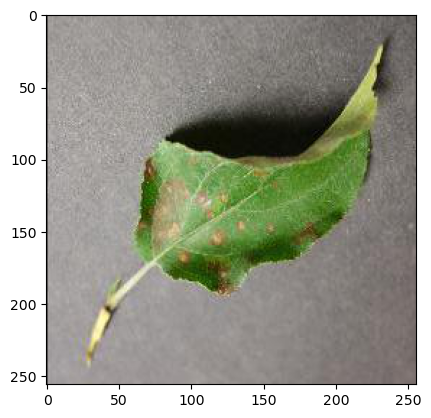

In [157]:
from torchvision import transforms

example_image = valid[1021]

show_image(*example_image)

image = example_image[0]
data_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

resized_img = data_transforms(image)

outputs = model_ft(resized_img.unsqueeze(0))
    
_, preds = torch.max(outputs, 1)

softmax_ = nn.Softmax(dim=1)
score_sm = softmax_(outputs)[0][preds]

print("\nPredicted Label:", idx_to_class_names[0][preds], "\nSoftmax Score:", score_sm.item())

In [159]:
%ls

'New Plant Diseases Dataset(Augmented)'/   Results_Visualization.ipynb
 Plants-ResNet18-Pretrained.ipynb          learned_model.pt
